In [2]:
"""imports"""
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [507]:
train_data_path = 'C:\\Users\\oeb\\Desktop\\New folder\\neural\\cifar-100-python\\train'
test_data_path ='C:\\Users\\oeb\\Desktop\\New folder\\neural\\cifar-100-python\\test'
classes = 'C:\\Users\\oeb\\Desktop\\New folder\\neural\\cifar-100-python\\meta'
train = unpickle(train_data_path)
test = unpickle(test_data_path)
classes = unpickle(classes)
classes.keys()

dict_keys([b'fine_label_names', b'coarse_label_names'])

## Datasets functions

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def normalizer(df):
    df = df /255.0
    return df

def gaussian(df):
    df = np.array(df)
    mean = df.mean()
    std = df.std()
    df = (df - mean)/std
    return df

def RGB_diffrence(i:int)->None:
    RED_TEST = test[b'data'][i].reshape(3,32,32).transpose(1,2,0)[:,:,0]
    GREEN_TEST = test[b'data'][i].reshape(3,32,32).transpose(1,2,0)[:,:,1]
    BLUE_TEST = test[b'data'][i].reshape(3,32,32).transpose(1,2,0)[:,:,2]
    # plot
    fig, axes = plt.subplots(1, 3)
    name = classes[b'fine_label_names'][test[b'fine_labels'][i]]
    plt.suptitle(f'diffrence between R & G & B in {name}', fontsize=12)
    images = [RED_TEST , GREEN_TEST, BLUE_TEST]
    for j in range(0, 3):
        axes[j].imshow(images[j]) ,axes[j].axis('off')

def one_color_extraction(df):
    l =df.shape[0]
    df_red = df.reshape(l,3,32,32).transpose(0,2,3,1)
    return df_red[:,:,:,0]

def reshaper(df):
    df = df.reshape(df.shape[0],  df.shape[1] *df.shape[2])
    return df

def pca_(df, features):
    pca = decomposition.PCA(n_components= features )
    df_transformed = pca.fit_transform(df)
    return df_transformed

# model implemntation

In [ ]:
def init_wights(hidden:int,inp:int):

    W = np.random.normal(0,0.25,size=(hidden,inp+1))
    #b = np.zeros((h1,1))
    return W 

def forward(weights,X):

    #z= weights.dot(x_train) + b
    z= weights.dot(X) 
    return z

def activation(z,y):

    # cast the acual labels to use it in hinge loss 
    classes = z.shape[0]
    o= (z.T * np.eye(classes)[y]).reshape(z.shape[1],z.shape[0]) 
    labels_vals = np.sum(o,axis=1)
    labels_vals_casted = (np.ones(z.shape)*labels_vals)

    #hinge loss weston watkins criterion
    loss= np.maximum(1+z-labels_vals_casted,0)
    return loss

def back_prop(loss,X,y,features:int,classes:int):

    # instead of indexing loss[label] = 0
    # because i couldn't
    loss = loss + -1.*np.ones_like(loss)
    loss = loss>0.0
    L = loss.T

    # labels to index the weights
    Y = np.eye(classes)[y]
    Y = Y > 0.0
    Y = Y.reshape(loss.shape[1],classes)

    delta =  [ np.zeros( ( Y.shape[0] ,features) ) for  i in range(classes)] # as a 3d tensor (classes X )

    s =np.sum(L[:,:],axis=1) #  number of other bigger prediction weights

    for r,w_r in enumerate(delta):
        p=X[:,L[:,r]].T
        # weight was bigger than the correct label
        w_r[ L[:,r] ] = X[:,L[:,r]].T
        # correct label = -Xi * s
        w_r[ Y[:,r] ]=  -1* X[:,Y[:,r]].T\
            * (s[Y[:,r]]).reshape(X[:,Y[:,r]].T.shape[0],1)
    delta = np.sum(delta,axis=1)
    return delta

def predict(weights,x):

    z= forward(weights, x)
    d = np.argmax(1+z,axis=0)
    return d

def accuracy(weights,x_train,y_train,x_test,y_test)-> (float,float):

    # over complexing the acc for plagiarism
    out = predict(weights, x_train)
    out_test = predict(weights, x_test)
    pred = out - y_train
    pred = np.absolute(pred)
    pred = (pred == 0.0)
    train_acc = np.sum(pred) / len(out)
    pred = out_test - y_test
    pred = np.absolute(pred)
    pred = (pred == 0.0)
    test_acc = np.sum(pred) / len(out_test)
    return train_acc*100 , test_acc*100

def mini_patcher(X,Y,batch_size:int=100):  

    m = X.shape[1]
    mini_batches = []
    num_complete_minibatches = (m // batch_size) 
    # Shuffle (X, Y)
    x = np.array(X).reshape(X.shape[0],m)
    Y = np.array(Y).reshape(1,m)
    permutation = list(np.random.permutation(m))
    shuffled_X = x[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))
    
    mini_batch_X = []
    mini_batch_Y = []
    for k in range(0, num_complete_minibatches):
        mini_batch_x = shuffled_X[ :, batch_size* k :batch_size* (k + 1)]
        mini_batch_y = shuffled_Y[ :, batch_size* k :batch_size* (k + 1)]
        mini_batch_X.append(mini_batch_x)
        mini_batch_Y.append(mini_batch_y.reshape(batch_size))
    return mini_batch_X , mini_batch_Y

def epoch(iterations:int,weights,x_train,y_train, x_test, y_test,v:float,s:float,t:int=0,optimizer="gd",alpha:float= 0.0001,lambd:float = 0):
    
    costs, acc_train, acc_test= [],[],[]
    m = x_train.shape[1]
    #lambd = 0.5

    for i in range (iterations):
        acc_x ,acc_y = accuracy(weights, x_train, y_train, x_test, y_test)
        acc_train.append(acc_x) , acc_test.append(acc_y)

        # L2 reg
        #reg_lambda = np.linalg.norm(weights)
        reg_lambda = np.sum(weights,axis=0)
        reg_cost = (lambd/(2*m))*(np.sum(np.square(weights))) 

        z = forward(weights, x_train)
        loss = activation(z, y_train)
        deltas = back_prop(loss,x_train,y_train,weights.T.shape[0], weights.T.shape[1])   
        
        #db = np.sum(deltas, axis=1, keepdims = True)
        deltas += (lambd*weights)/m   
        if optimizer.lower() == "adam":
            t += 1
            weights, v, s, _, _ =update_parameters_with_momentum(weights,
             deltas, v, s, t, alpha=alpha)  
            #b, v, s, _, _ =update_parameters_with_momentum(b,db, vb,sb, t, alpha=alpha/10)  
        else:
            weights = weights - alpha * deltas/m
            #b += -(alpha**2)*(1./m) * db   
        costs.append(np.linalg.norm(deltas)/m + reg_cost)
    return weights , costs , acc_train, acc_test

def epoch_minpatch(iterations:int,weights,x_train,y_train, x_test, y_test,optimizer:str="gd",alpha:float= 0.00001,batch_size:int=100,lambd:float = 0):

    x_train_list , y_train_list = mini_patcher(x_train, y_train,batch_size=batch_size)
    costs,X_acc , Y_acc =[], [], []
    t=0
    v,s = initialize_adam(weights=weights)
    #vb,sb = initialize_adam(weights=b)
    for i in range(iterations):
        for i,val in enumerate(x_train_list):
            weights, cost , x_acc , y_acc =epoch(1, weights,
                                                val, y_train_list[i] ,
                                                x_test, y_test,
                                                v,s,
                                                t=t,
                                                optimizer=optimizer,
                                                alpha=alpha,
                                                lambd= lambd)
            costs += cost
            X_acc += x_acc
            Y_acc += y_acc
    return weights , costs , X_acc , Y_acc 

def eval(x:list,y:list,cost:list,text1='train acc',text2='test acc' ):

    fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(16,8))
    ax1.plot(cost);
    ax1.set_title('cost vs epoches')
    ax1.set_ylabel('cost')
    ax2.plot(x);
    ax2.plot(y);
    plt.legend([text1,text2]);
    ax2.set_xlabel('number of epoches')
    ax2.set_ylabel('accuracy %')
    ax2.set_title('accuracy vs epoches');

def plotter(x:list,y:list)->None:

    plt.plot(x);
    plt.plot(y);
    plt.legend(['train acc','test acc']);
    plt.show();

def initialize_adam(weights):
    
    v = np.zeros_like(weights)
    s = np.zeros_like(weights)
    return v ,s

def update_parameters_with_momentum(weights, grads, v,s, t, alpha,
                                    beta1 = 0.9, beta2 = 0.999,
                                    epsilon = 1e-8):

    v = beta1 * v + (1- beta1) * grads
    v_correct = v / (1- beta1** t)
    s = beta2 * s + (1- beta2) * grads**2
    s_correct = s / (1- beta2** t)
    weights = weights -alpha*v_correct / (np.sqrt(s_correct)+epsilon)

    return weights, v, s, v_correct, s_correct

# 10 feautres only 100 samples adam
50 K adam

In [560]:
train = unpickle(train_data_path)
test = unpickle(test_data_path)

train[b'data'] , test[b'data'] = normalizer(train[b'data']) , normalizer(test[b'data'])
train[b'data'] , test[b'data'] = gaussian(train[b'data'])   , gaussian(test[b'data'])
train[b'data'] , test[b'data'] = one_color_extraction(train[b'data']) , one_color_extraction(test[b'data'])
train[b'data'] , test[b'data'] = reshaper(train[b'data'])   ,reshaper(test[b'data'])


In [561]:
x_train,x_test = pca_(train[b'data'], 10).T ,pca_(test[b'data'], 10).T

y_train = train[b'fine_labels'] 
y_test = test[b'fine_labels']

# add 1 for homogenous (bias) 
x_train = np.vstack((x_train,np.ones((50000))))

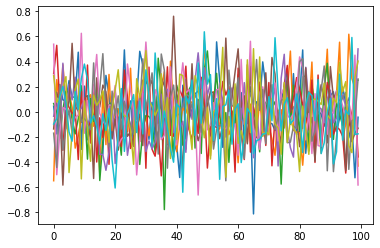

In [563]:
weights = init_wights(100,10)
plt.plot(weights);

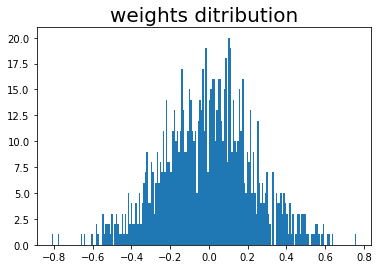

In [564]:
plt.hist(weights.reshape(100*10,1), bins=200);
plt.title('weights ditribution', size =20);

In [565]:
weights , costs , train_acc , test_acc = epoch(10*5000, weights,
                                                         x_train[:,:100], y_train[:100],
                                                          x_train[:,:110], y_train[:110],
                                                            optimizer="adam"
                                                            ,alpha=0.0001,batch_size=100,lambd=.0
                                                          )                                                       

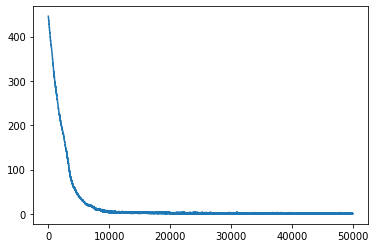

In [566]:
plt.plot(costs);

In [567]:
costs[-1],min(costs),max(real_x),min(train_acc)

(0.0, 0.0, 1.0, 0.0)

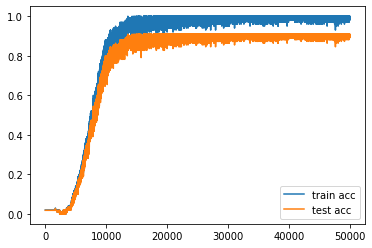

In [569]:
plotter(train_acc, test_acc)

In [570]:
"10 features 50k epoch adam"
pred= predict(weights, x_train[:,:110])
testing_acc = np.sum(pred==y_train[:110]) / 110 
testing_acc *100

89.0909090909091